- Sankey plot of clear OBS number for each landfill
- Sankey plot of landfill emissions

In [1]:
import os
import pandas as pd
from glob import glob
import numpy as np
from itertools import chain
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import to_hex
from matplotlib import rcParams
import matplotlib.colors as mcolors

In [2]:
# set basic matplotlib settings
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['tex gyre heros']

font_size = 17
rcParams['axes.titlesize'] = font_size
rcParams['axes.labelsize'] = font_size - 2
rcParams['xtick.labelsize'] = font_size - 2
rcParams['ytick.labelsize'] = font_size - 2
rcParams['legend.fontsize'] = font_size
rcParams['figure.titlesize'] = font_size
rcParams['figure.titleweight'] = 'bold'

## Group OBS data by country and landfill name

In [3]:
data_dir = '../data/Hyper_TROPOMI_landfill/'

filelist = list(chain(*[glob(os.path.join(data_dir, '**', '*csv'), recursive=True)]))

df = pd.concat((pd.read_csv(f) for f in filelist), ignore_index=True)
# df['emission_uncertainty_percentage'] = df['emission_uncertainty']/df['emission']*100
# # convert units to t/h
# df['emission'] /= 1e3

In [4]:
df_grp = df.groupby(['country', 'name', 'platform'], as_index=False).size().rename(columns={'size': 'count'})

# calculate sum by group
# https://stackoverflow.com/a/63201382/7347925
coutry_sum = df_grp['count'].groupby(df_grp.country).transform('sum')

# sort values in descending order
df_grp = df_grp.loc[(-coutry_sum).argsort()]

In [5]:
df_grp

,country,name,platform,count
27,India,Pirana,PRISMA,5
24,India,Okhla,EMIT,2
23,India,Manter Wadi,EMIT,1
22,India,Majura,EMIT,3
21,India,Kanjurmarg,PRISMA,2
20,India,Kanjurmarg,EnMAP,1
19,India,Kanjurmarg,EMIT,1
18,India,Kachara,EMIT,1
17,India,Ghazipur,EnMAP,5
16,India,Ghazipur,EMIT,4


In [6]:
df_grp['platform'].value_counts()

platform
EMIT      36
EnMAP     16
PRISMA     4
Name: count, dtype: int64

In [7]:
obs_num = df_grp.groupby('name')['count'].sum()
print(len(obs_num[obs_num>1])/len(obs_num)*100, 'percent landfills are observed at least twice.')

73.68421052631578 percent landfills are observed at least twice.


In [8]:
obs_num.sort_values(ascending=False)

name
Ghabawi                            14
Riyadh                             11
Kabd                               10
Tamar                              10
Tehran                              9
Dudaim                              9
Ghazipur                            9
Akhangaran                          8
Norte III                           8
Mashhad                             8
Okhla                               7
Al Akaider                          7
Bhalswa                             6
Pirana                              6
Simeprodeso                         5
Ürümqi                              5
Jebel Chakir                        5
González Catán                      5
Kanjurmarg                          4
Bandhwari                           4
Charlotte Motor Speedway            3
Tecnosilicatos                      3
Relleno Sanitario Peña De Gatos     3
Majura                              3
Piedra Blanca                       2
Deonar                              2
Seminol

In [9]:
# https://stackoverflow.com/a/70296887/7347925

categories = ['country', 'name', 'platform']

df_counts = pd.DataFrame()
for i in range(len(categories)-1):
    # calculate the counts: country -> name, name -> platform
    tempDf = df_grp[[categories[i], categories[i+1],'count']].rename(columns={categories[i]: 'source', categories[i+1]: 'target'})\
                                                            .groupby(['source','target']).agg({'count':'sum'}).reset_index()
    df_counts = pd.concat([df_counts,tempDf])

# get the label list in order
label_list = list(df_grp[categories].melt().drop('variable',axis=1)['value'].drop_duplicates().values)

source = df_counts['source'].apply(lambda x: label_list.index(x))
target = df_counts['target'].apply(lambda x: label_list.index(x))
count = df_counts['count']

# calculate the counts of each label
df_country_count = df_grp.groupby(['country']).agg({'count':'sum'}).reset_index()
df_landfill_count = df_grp.groupby(['name']).agg({'count':'sum'}).reset_index()
df_platform_count = df_grp.groupby(['platform']).agg({'count':'sum'}).reset_index()

# add obs number to label list
for index,label in enumerate(label_list):
    if any(df_country_count['country'].str.contains(label)):
        # get the row of country counts
        df_subset = df_country_count[df_country_count['country']==label]
        # create new label
        new_label = (df_subset['country'] + ' (' + df_subset['count'].astype('str')).values[0] + ')'
    elif any(df_landfill_count['name'].str.contains(label)):
        # get the row of landfill counts
        df_subset = df_landfill_count[df_landfill_count['name']==label]
        # create new label 
        new_label = (df_subset['name'] + ' (' + df_subset['count'].astype('str')).values[0] + ')'
    elif any(df_platform_count['platform'].str.contains(label)):
        # get the row of landfill counts
        df_subset = df_platform_count[df_platform_count['platform']==label]
        # create new label 
        new_label = (df_subset['platform'] + ' (' + df_subset['count'].astype('str')).values[0] + ')'
    # update the label list
    label_list[index] = new_label

fig = go.Figure(data=[go.Sankey(
    node = {"label": label_list},
    link = {"source": source, "target": target, "value": count}
    )])

fig.update_layout(
    title_text="",
    font=dict(
        family='sans-serif',
        size=20,
        # color="RebeccaPurple"
    ),
    autosize=False,
    width=1200,
    height=1200,
)

fig.add_annotation(x=0, y=1.08, text='<b>Countries</b>', showarrow=False,
                   font=dict(size=28),align="center"
                   )

fig.add_annotation(x=0.55, y=1.08, text='<b>Landfills</b>', showarrow=False,
                   font=dict(size=28),align="center"
                   )

fig.add_annotation(x=1, y=1.08, text='<b>HSI Instruments</b>', showarrow=False,
                   font=dict(size=28),align="center"
                   )

fig.write_image('../figures/obs_sankey.pdf', scale=3)
fig.show()

## Group Emission data by country and landfill name

In [10]:
df_summary = pd.read_csv('../data/landfills_hyper_summary.csv')

df_emiss = df_summary.groupby(['country', 'name'], as_index=False).agg({'emission':'mean', 'emission_uncertainty(%)': 'mean'})#, 'plume_id': 'count'}).rename(columns={'plume_id': 'count'})

# calculate sum by country group        
coutry_sum_emission = df_emiss['emission'].groupby(df_emiss.country).transform('sum')

df_emiss = df_emiss.assign(sum_emission=coutry_sum_emission).sort_values(['sum_emission', 'emission'], ascending=False).reset_index(drop=True)

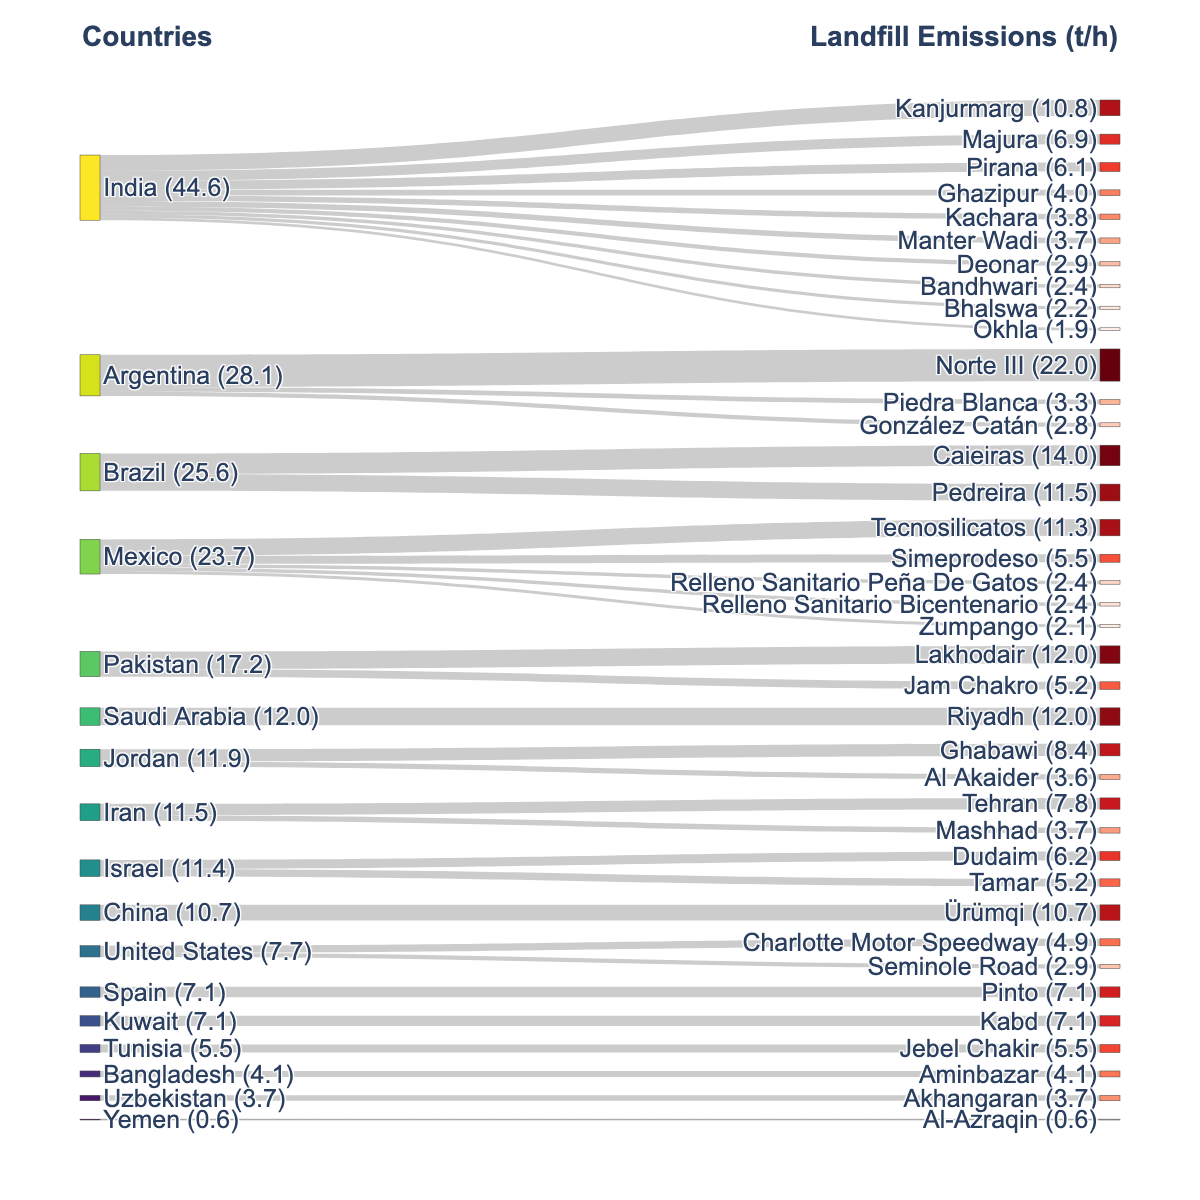

In [11]:
# df_emiss_sankey = df_emiss[['country', 'name', 'emission']].rename(columns={'country': 'source', 'name': 'target'}).groupby(['source','target']).agg({'emission':'sum'}).reset_index()
# df_emiss_sankey = df_emiss_sankey.sort_values('emission', ascending=False)

# get the label list (country name + landfill name) in order
label_list = list(df_emiss[['country', 'name']].melt().drop('variable',axis=1)['value'].drop_duplicates().values)

# get the country name list in the order of country emissions
index_country = len(df_emiss['country'].drop_duplicates())
country_list = label_list[:index_country]

# create colors based on cmap and length in the order of emission values
country_color = matplotlib.pyplot.get_cmap('viridis_r', lut=len(country_list))
landfill_color = matplotlib.pyplot.get_cmap('Reds_r', lut=len(df_emiss))


if isinstance(landfill_color, matplotlib.colors.LinearSegmentedColormap):
    landfill_color = [mcolors.rgb2hex(landfill_color(i)) for i in range(landfill_color.N)]
else:
    # set color based on all landfill emissions
    landfill_color = [to_hex(c) for c in landfill_color.colors]
# sort color based on emission values (descending)
sort_index = np.argsort(np.argsort(-df_emiss['emission'].values))
 #df_emiss['emission'].reset_index(drop=True).sort_values(ascending=False).index.tolist()
landfill_color = [landfill_color[i] for i in sort_index]
country_color = [to_hex(c) for c in country_color.colors]

# # --- set color by landfill emission per country group ---

source = df_emiss['country'].apply(lambda x: label_list.index(x))
target = df_emiss['name'].apply(lambda x: label_list.index(x))
emission = df_emiss['emission']

# calculate the counts of each label
df_country_emiss = df_emiss.groupby(['country'], sort=False).agg({'emission':'sum'}).reset_index()
df_landfill_emiss = df_emiss.groupby(['name'], sort=False).agg({'emission':'sum'}).reset_index()
# round data
df_country_emiss['emission'] = df_country_emiss['emission'].round(1)
df_landfill_emiss['emission'] = df_landfill_emiss['emission'].round(1)
# calculate width by value proportion
df_landfill_emiss['bar_width'] = df_landfill_emiss['emission']/df_landfill_emiss['emission'].sum()

# add obs number to label list
for index,label in enumerate(label_list):
    if any(df_country_emiss['country'].str.contains(label)):
        # get the row of country counts
        df_subset = df_country_emiss[df_country_emiss['country']==label]
        # create new label
        new_label = (df_subset['country'] + ' (' + df_subset['emission'].astype('str')).values[0] + ')'
        # new_label = df_subset['country']
    elif any(df_landfill_emiss['name'].str.contains(label)):
        # get the row of landfill counts
        df_subset = df_landfill_emiss[df_landfill_emiss['name']==label]
        # create new label 
        new_label = (df_subset['name'] + ' (' + df_subset['emission'].astype('str')).values[0] + ')'
        # new_label = df_subset['name']
    # update the label list
    label_list[index] = new_label


fig = go.Figure(data=[go.Sankey(
    # orientation = "v",
    node = {"label": label_list,
            'color': country_color+landfill_color,
            },
    link = {"source": source, "target": target, "value": emission}
    )])

fig.add_annotation(x=0, y=1.08, text='<b>Countries</b>', showarrow=False,
                   font=dict(size=28),align="center"
                   )

fig.add_annotation(x=1, y=1.08, text='<b>Landfill Emissions (t/h)</b>', showarrow=False,
                   font=dict(size=28),align="center"
                   )

fig.update_layout(
    font=dict(
        family='sans-serif',
        size=25,
        # color="RebeccaPurple"
    ),
    autosize=False,
    width=1200,
    height=1200,
)

# interactive shown in notebook
# fig.show()

fig.show('png')

In [12]:
def adjust_width(array, min_width=0.022):
    smallest_value = min(array)
    if smallest_value < min_width:
        array = [min_width + (value - smallest_value) for value in array]
    array_sum = sum(array)
    adjusted_array = [value / array_sum for value in array]
    return adjusted_array

row_height = adjust_width(df_landfill_emiss['bar_width'].to_numpy())
# row_height[0] -= 0.008

In [13]:
df_emiss_grp = df_summary.groupby(['name', 'platform']).agg(mean=('emission', 'mean'), std=('emission_uncertainty(%)', 'mean')).reset_index()
df_emiss_grp['std'] = df_emiss_grp['mean'] * df_emiss_grp['std'] * 1e-2

# read OBS data for checking landfills which have OBS but no plume
df_obs = pd.read_excel('../data/landfills_hyper_obs.xlsx')
# remove space at end
df_obs['name'] = df_obs['name'].str.strip()

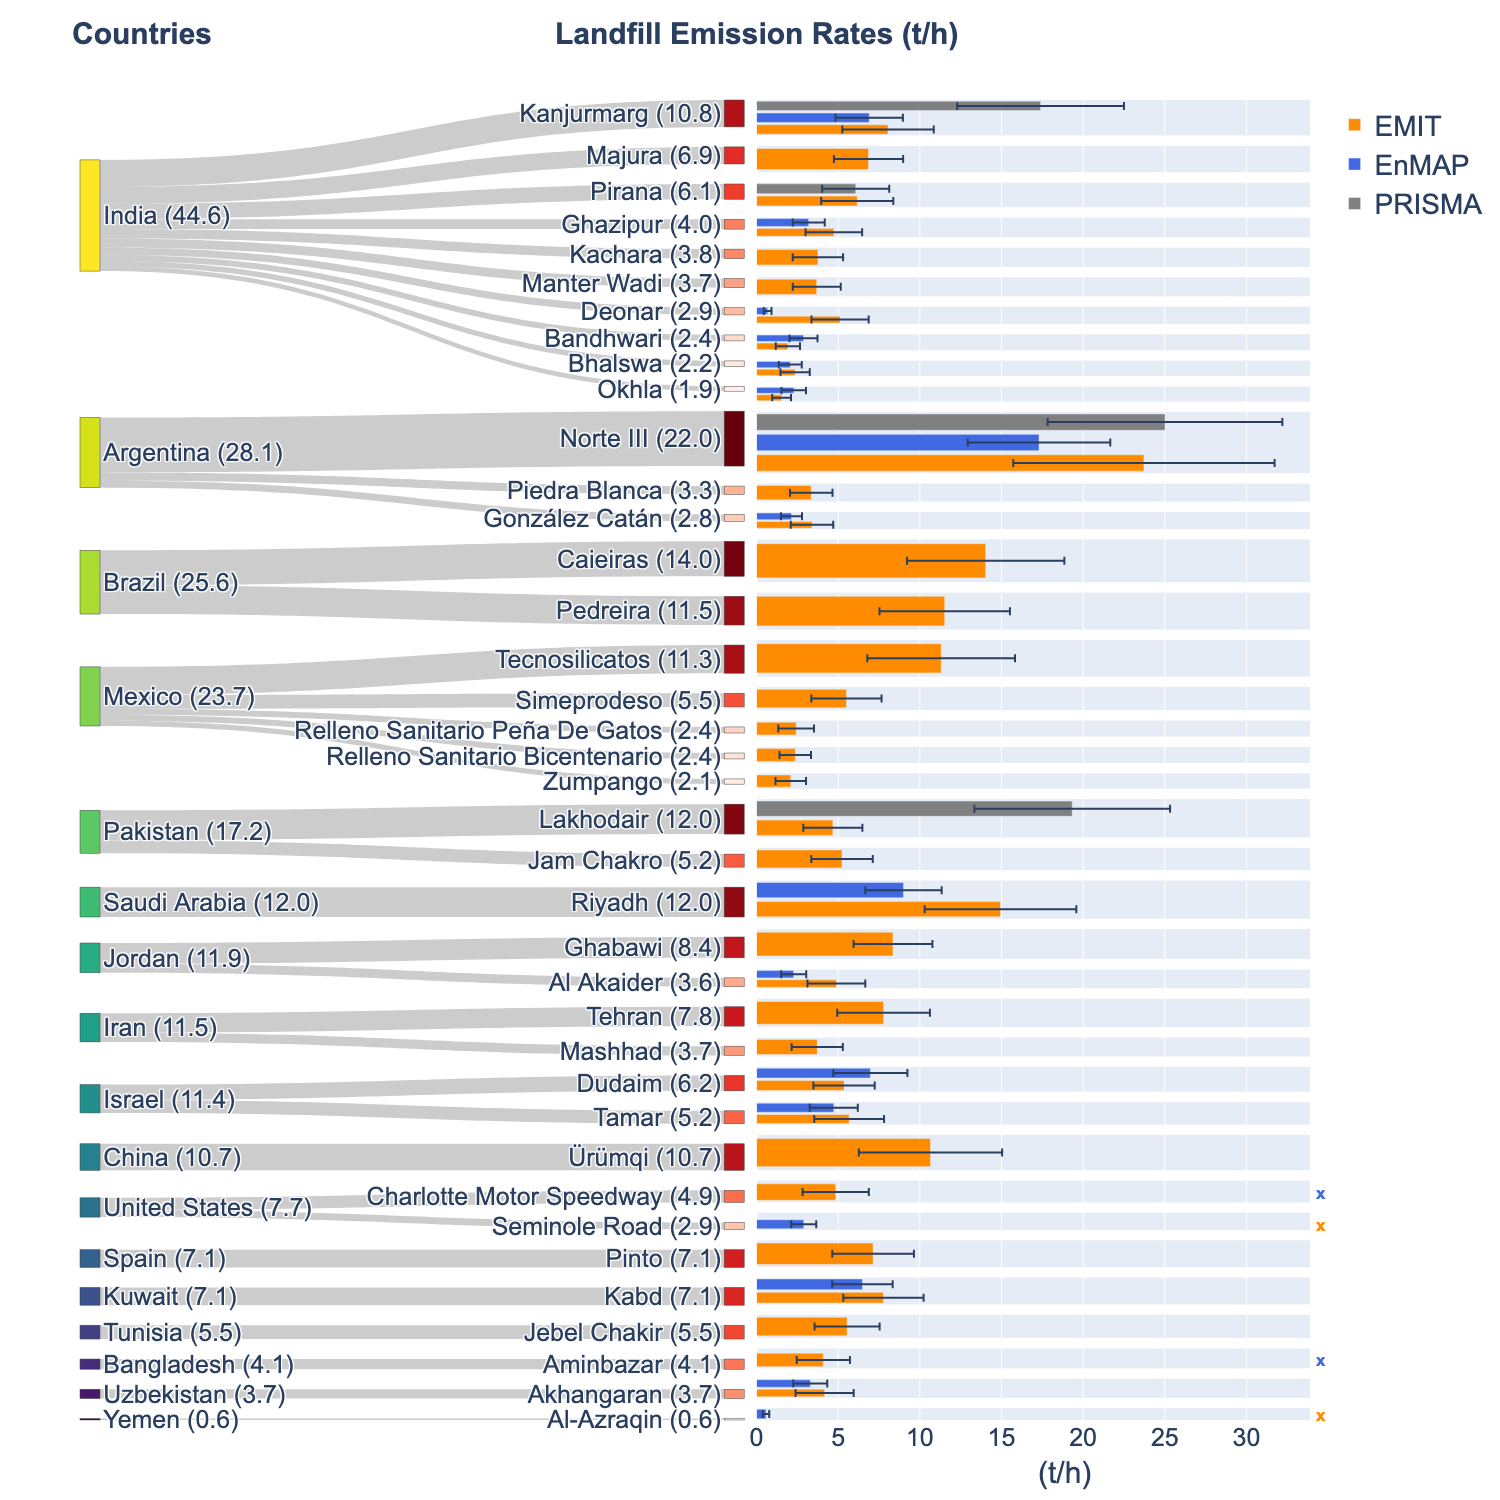

In [14]:
type_colors = {'EMIT': 'darkorange',
               'EnMAP': 'royalblue',
               'PRISMA': 'gray'}

trace_sankey = go.Sankey(
    # orientation = 'v',
    node = {"label": label_list,
            'color': country_color+landfill_color,
            # 'pad': 50,
            },
    link = {"source": source, "target": target, "value": emission},
    domain={'x': [0, 0.54]},
    )

fig = make_subplots(rows=len(landfill_color), cols=2,
                    row_heights=row_height,
                    # row_heights=df_landfill_emiss['bar_width'].to_list(),
                    shared_xaxes=True,
)

fig.add_trace(trace_sankey)

# error bar plot
all_platforms =  ['EMIT', 'EnMAP', 'PRISMA']
row = 1
for name in df_emiss['name']:
    landfill_data = df_emiss_grp[df_emiss_grp['name'] == name]
    # add row for no plume is detected but valid
    df_summary_landfill = df_summary[df_summary['name']==name]
    available_platforms = df_emiss_grp[df_emiss_grp['name']==name]['platform']
    rest_platforms = list(np.setdiff1d(all_platforms, available_platforms))

    # plot bars
    for _, row_data in landfill_data.iterrows():
        fig.add_trace(
            go.Bar(y=[row_data['platform']], x=[row_data['mean']], orientation='h',
                   name=row_data['platform'], marker_color=type_colors[row_data['platform']],
                #    xaxis=f'x{row}',
                   width=0.8,
            error_x=dict(
                        type='data', # value of error bar given in data coordinates
                        array=np.array(row_data['std']),
                        visible=True)
                   ),
            row=row, col=2
        )

    # plot cross for landfills which have OBS but no plume
    for index, rest_platform in enumerate(rest_platforms):
        df_row = df_obs[df_obs['name']==name]
        if (df_row[f'overpass({rest_platform.lower()})'].values>0) and (df_row[f'plume({rest_platform.lower()})'].values==0):
            if rest_platform == 'PRISMA':
                x = 1.04
            else:
                x = 1.03
                fig.add_annotation(
                    dict(
                        font=dict(
                            color=type_colors[rest_platform],
                            size=17
                        ),
                        x=x,
                        xref='x domain',
                        y=row_data['platform'],
                        showarrow=False,
                        text="<b>x</b>",
                        textangle=0,
                    ),
                        row=row, col=2,
                )

    row += 1

# https://stackoverflow.com/a/62162555/7347925
names = set()
fig.for_each_trace(
    lambda trace:
        trace.update(showlegend=False)
        if (trace.name in names) else names.add(trace.name))

fig.update_yaxes(showticklabels=False) # Hide y axis ticks

fig.update_layout(
    font=dict(
        family='sans-serif',
        size=25,
        # size=32,
        # color="RebeccaPurple"
    ),
    autosize=False,
    width=1500,
    height=1500,
    xaxis2=dict(
        range=(0, 35)
    ),
    legend=dict(font=dict(size=28), itemwidth=30),
)

fig.add_annotation(dict(x=0.05, y=1.05, ax=0, ay=0,
                    xref = "paper", yref = "paper", 
                    font=dict(size=30), text= "<b>Countries</b>",
                  ))

fig.add_annotation(dict(x=0.55, y=1.05, ax=0, ay=0,
                    xref = "paper", yref = "paper", 
                    font=dict(size=30), text= "<b>Landfill Emission Rates (t/h)</b>",
                  ))
fig.add_annotation(dict(x=0.8, y=-0.04, ax=0, ay=0,
                    xref = "paper", yref = "paper", 
                    font=dict(size=30), text= "(t/h)",
                  ))
                  
fig.write_image('../figures/emission_sankey.pdf', scale=3)

# interactive shown in notebook
# fig.show()

fig.show('png')

In [15]:
df_emiss_grp

,name,platform,mean,std
0,Akhangaran,EMIT,4.172113,1.778355
1,Akhangaran,EnMAP,3.297479,1.040354
2,Al Akaider,EMIT,4.890580,1.771538
3,Al Akaider,EnMAP,2.275887,0.763646
4,Al-Azraqin,EnMAP,0.582031,0.193089
5,Aminbazar,EMIT,4.092617,1.629317
6,Bandhwari,EMIT,1.920719,0.744697
7,Bandhwari,EnMAP,2.875267,0.859048
8,Bhalswa,EMIT,2.363708,0.889917
9,Bhalswa,EnMAP,2.066236,0.705554
